In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Importation et Netoyage des données

In [7]:
# Charger les données

# Charger votre base de données
df = pd.read_csv('resultat.csv')
    
# Afficher les premières lignes pour comprendre la structure
print("Aperçu des données:")
print(df.head())


Aperçu des données:
   Batch name     t1     t2     t3     t4     t5     t6     t7     t8     t9  \
0  Batch_1006  52.97  27.05  26.60  26.15  25.70  24.79  24.35  23.90  23.44   
1   Batch_103  23.29  35.47  26.60  28.10  28.55  29.46  29.90  62.21  78.67   
2  Batch_1173  70.92  21.27  21.20  21.20  21.20  21.20  21.34  71.00  70.85   
3    Batch_12  20.14  40.27  39.90  39.67  39.90  32.46  27.73  22.55  22.55   
4  Batch_1206  35.77  35.62  35.77  35.77  35.84  36.07  36.07  36.21  36.07   

   ...  t15075  t15076  t15077  t15078  t15079  t15080  t15081  Impureté a  \
0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.00   
1  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.12   
2  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.06   
3  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.07   
4  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.19   

   Impureté b  Impureté c  
0 

# Imputation par la moyenne de ligne

Nombre de colonnes de température: 15081
Nombre de valeurs manquantes initialement: 3717084


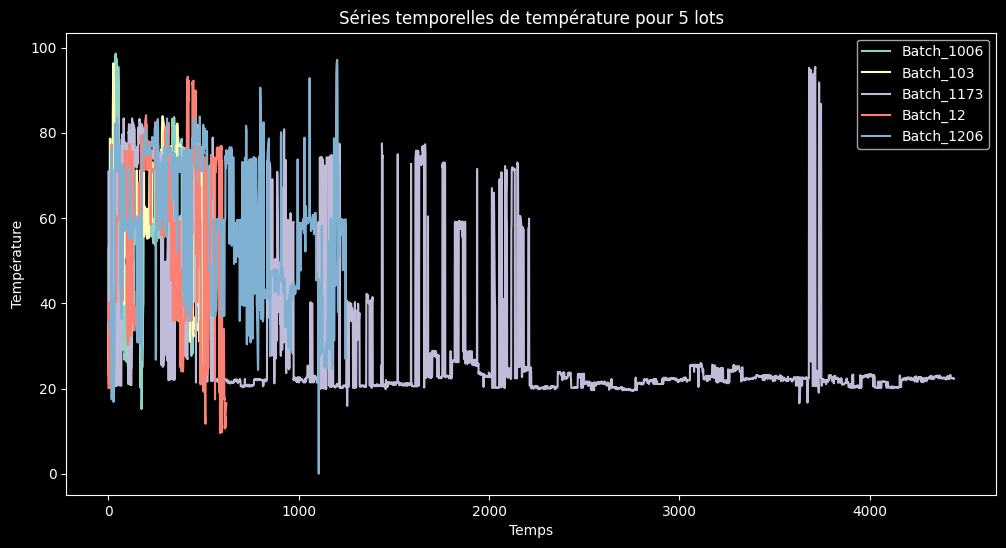

In [ ]:
# Identifions les types de colonnes
temp_columns = [col for col in df.columns if col.startswith('t') and col[1:].isdigit()]
other_columns = ['Batch name', 'Impureté a', 'Impureté b', 'Impureté c']
print(f"Nombre de colonnes de température: {len(temp_columns)}")
print(f"Nombre de valeurs manquantes initialement: {df[temp_columns].isna().sum().sum()}")
# Visualisons quelques séries temporelles avant traitement
plt.figure(figsize=(12, 6))
for i, batch in enumerate(df['Batch name'].head(5)):
    batch_data = df[df['Batch name'] == batch]
    temps = batch_data[temp_columns].values.flatten()
    valid_indices = ~np.isnan(temps)
    plt.plot(np.arange(len(temps))[valid_indices], temps[valid_indices], label=batch)

plt.title('Séries temporelles de température pour 5 lots')
plt.xlabel('Temps')
plt.ylabel('Température')
plt.legend()

plt.show()

In [10]:
# Approche 1: Imputation par la moyenne de ligne (version optimisée)
df_mean_row = df.copy()

# Calculer la moyenne par ligne pour toutes les colonnes de température en une seule opération
row_means = df_mean_row[temp_columns].mean(axis=1)

# Pour chaque colonne de température, remplacer les NaN par la moyenne de la ligne correspondante
for col in temp_columns:
    df_mean_row[col].fillna(row_means, inplace=True)

print(f"Valeurs manquantes après imputation par moyenne de ligne: {df_mean_row[temp_columns].isna().sum().sum()}")

/var/folders/pc/n0rtbv2j71vbpvb5j0t7fwn40000gn/T/ipykernel_47131/38776225.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mean_row[col].fillna(row_means, inplace=True)


Valeurs manquantes après imputation par moyenne de ligne: 0


Valeurs manquantes après interpolation: 0
Nombre de lots avec caractéristiques extraites: 264
   Batch name  Temp_Mean   Temp_Std  Temp_Min  Temp_Max  Temp_Range  \
0  Batch_1006  57.474523  18.821928     15.18     98.57       83.39   
1   Batch_103  59.027972  16.552876     20.21     96.32       76.11   
2  Batch_1173  29.988323  17.407888     15.94     95.49       79.55   
3    Batch_12  55.216167  20.651518      9.55     93.17       83.62   
4  Batch_1206  57.403221  16.728521      0.00     97.14       97.14   

   Temp_25th  Temp_Median  Temp_75th  Impureté a  Impureté b  Impureté c  
0    39.8600        59.28    73.6700        0.00        0.00   48.614958  
1    41.1150        59.35    73.1800        0.12        0.09   57.635468  
2    21.1200        22.32    25.5100        0.06        0.00   39.344262  
3    38.9200        58.98    74.0800        0.07        0.08    4.069767  
4    42.8025        58.61    73.8775        0.19        0.10   57.905138  


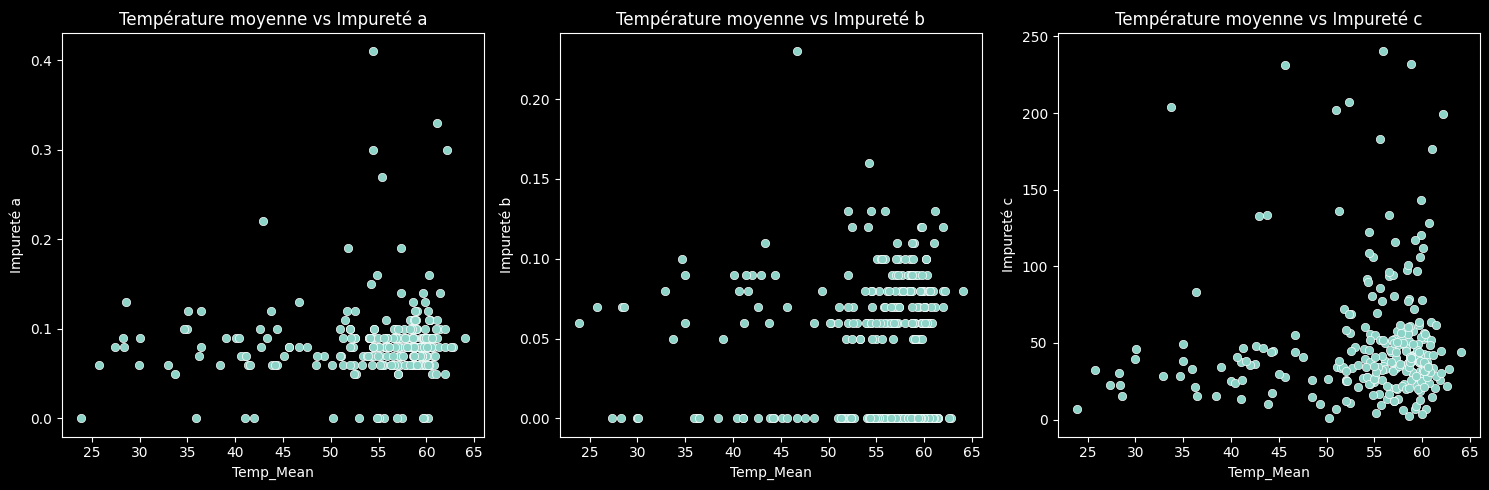

In [12]:
# Approche 2: Interpolation par lot
df_interp = df.copy()

for batch in df_interp['Batch name'].unique():
    mask = df_interp['Batch name'] == batch
    # Sélectionner uniquement les colonnes de température pour ce lot
    temp_vals = df_interp.loc[mask, temp_columns]
    # Interpolation linéaire
    df_interp.loc[mask, temp_columns] = temp_vals.interpolate(method='linear', axis=1, limit_direction='both')

print(f"Valeurs manquantes après interpolation: {df_interp[temp_columns].isna().sum().sum()}")

# Approche 3: Extraction de caractéristiques sans remplacement
batch_features = []

for batch in df['Batch name'].unique():
    batch_data = df[df['Batch name'] == batch]
    
    # Extraire la série temporelle (sans les NaN)
    temp_series = batch_data[temp_columns].values.flatten()
    temp_series = temp_series[~np.isnan(temp_series)]
    
    if len(temp_series) > 0:  # s'il y a au moins une valeur non-NaN
        # Calculer les caractéristiques
        features = {
            'Batch name': batch,
            'Temp_Mean': np.mean(temp_series),
            'Temp_Std': np.std(temp_series),
            'Temp_Min': np.min(temp_series),
            'Temp_Max': np.max(temp_series),
            'Temp_Range': np.max(temp_series) - np.min(temp_series),
            'Temp_25th': np.percentile(temp_series, 25),
            'Temp_Median': np.median(temp_series),
            'Temp_75th': np.percentile(temp_series, 75)
        }
        
        # Ajouter les valeurs d'impureté
        features['Impureté a'] = batch_data['Impureté a'].iloc[0]
        features['Impureté b'] = batch_data['Impureté b'].iloc[0]
        features['Impureté c'] = batch_data['Impureté c'].iloc[0]
        
        batch_features.append(features)

# Créer un nouveau DataFrame avec les caractéristiques extraites
features_df = pd.DataFrame(batch_features)
print(f"Nombre de lots avec caractéristiques extraites: {len(features_df)}")
print(features_df.head())

# Visualisons la relation entre les caractéristiques de température et les impuretés
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Temp_Mean', y='Impureté a', data=features_df)
plt.title('Température moyenne vs Impureté a')

plt.subplot(1, 3, 2)
sns.scatterplot(x='Temp_Mean', y='Impureté b', data=features_df)
plt.title('Température moyenne vs Impureté b')

plt.subplot(1, 3, 3)
sns.scatterplot(x='Temp_Mean', y='Impureté c', data=features_df)
plt.title('Température moyenne vs Impureté c')

plt.tight_layout()
plt.show()


Aperçu des données:
   Batch name     t1     t2     t3     t4     t5     t6     t7     t8     t9  \
0  Batch_1006  52.97  27.05  26.60  26.15  25.70  24.79  24.35  23.90  23.44   
1   Batch_103  23.29  35.47  26.60  28.10  28.55  29.46  29.90  62.21  78.67   
2  Batch_1173  70.92  21.27  21.20  21.20  21.20  21.20  21.34  71.00  70.85   
3    Batch_12  20.14  40.27  39.90  39.67  39.90  32.46  27.73  22.55  22.55   
4  Batch_1206  35.77  35.62  35.77  35.77  35.84  36.07  36.07  36.21  36.07   

   ...  t15075  t15076  t15077  t15078  t15079  t15080  t15081  Impureté a  \
0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.00   
1  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.12   
2  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.06   
3  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.07   
4  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN        0.19   

   Impureté b  Impureté c  
0 

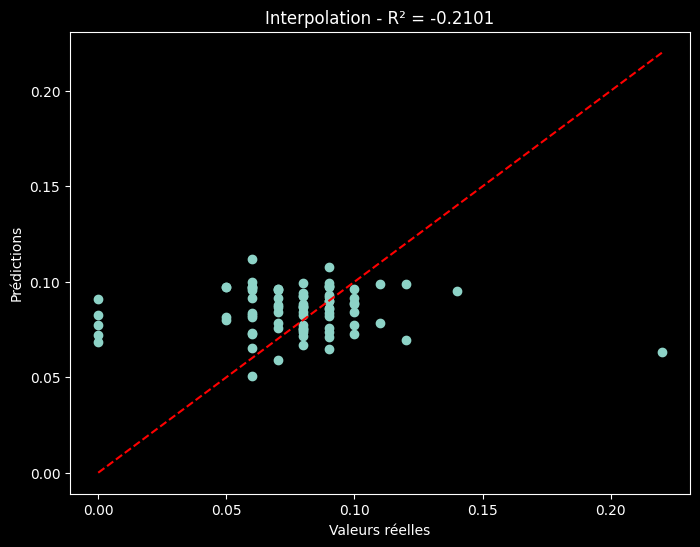

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Charger les données
df = pd.read_csv('resultat.csv')
print("Aperçu des données:")
print(df.head())

# Identifier les colonnes de température
temp_columns = [col for col in df.columns if col.startswith('t') and col[1:].isdigit()]
print(f"Nombre de colonnes de température: {len(temp_columns)}")
print(f"Nombre de valeurs manquantes initialement: {df[temp_columns].isna().sum().sum()}")

# Approche: Interpolation par lot
df_interp = df.copy()
for batch in df_interp['Batch name'].unique():
    mask = df_interp['Batch name'] == batch
    temp_vals = df_interp.loc[mask, temp_columns]
    df_interp.loc[mask, temp_columns] = temp_vals.interpolate(method='linear', axis=1, limit_direction='both')

print(f"Valeurs manquantes après interpolation: {df_interp[temp_columns].isna().sum().sum()}")

# Extraction des caractéristiques par lot
interp_features = []
for batch in df_interp['Batch name'].unique():
    batch_data = df_interp[df_interp['Batch name'] == batch]
    temp_values = batch_data[temp_columns].values.flatten()
    features = {
        'Batch name': batch,
        'Temp_Mean': np.mean(temp_values),
        'Temp_Std': np.std(temp_values),
        'Temp_Min': np.min(temp_values),
        'Temp_Max': np.max(temp_values),
        'Temp_Range': np.max(temp_values) - np.min(temp_values),
        'Temp_Median': np.median(temp_values),
        'Impureté a': batch_data['Impureté a'].iloc[0]
    }
    interp_features.append(features)

interp_df = pd.DataFrame(interp_features)

# Modèle de régression
X = interp_df[['Temp_Mean', 'Temp_Std', 'Temp_Min', 'Temp_Max', 'Temp_Range', 'Temp_Median']]
y = interp_df['Impureté a']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_interp = LinearRegression()
model_interp.fit(X_train, y_train)
y_pred_interp = model_interp.predict(X_test)

# Évaluation
rmse_interp = np.sqrt(mean_squared_error(y_test, y_pred_interp))
r2_interp = r2_score(y_test, y_pred_interp)

print("\nRésultats de la régression avec interpolation:")
print(f"RMSE: {rmse_interp:.4f}")
print(f"R²: {r2_interp:.4f}")
print("Coefficients:", model_interp.coef_)
print("Intercept:", model_interp.intercept_)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_interp)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'Interpolation - R² = {r2_interp:.4f}')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.show()
